In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r'D:\predictive maintenence\data\ai4i2020_final.csv')
df.columns

Index(['type', 'process_temp', 'rot_speed', 'torque', 'tool_wear',
       'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf', 'temp_diff',
       'heating_risk_scaled', 'power', 'wear_z', 'mechanical_work'],
      dtype='object')

In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# 1) Prepare
features = [
    'type','process_temp','rot_speed','torque',
    'tool_wear','temp_diff','heating_risk_scaled',
    'power','wear_z','mechanical_work'
]
X = df[features]
y = df['machine_failure']

# 2) Split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Train with your best‐found settings
scale_pos = (1 - y_tr.mean()) / y_tr.mean()
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
xgb.fit(X_tr, y_tr)

# 4) Get predictions
probs = xgb.predict_proba(X_te)[:,1]
thr = 0.8975   # your F1-optimum threshold
preds = (probs >= thr).astype(int)

# 5) Overall metrics
print(classification_report(y_te, preds, digits=4))

# 6) Extract FNs & FPs for analysis
te = X_te.copy()
te['y_true'] = y_te
te['y_pred'] = preds

fn = te[(te['y_true']==1) & (te['y_pred']==0)]
fp = te[(te['y_true']==0) & (te['y_pred']==1)]

print(f"\nFalse Negatives: {len(fn)} rows")
print(f"False Positives: {len(fp)} rows")




d:\predictive maintenence\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.9928    0.9984    0.9956      1932
           1     0.9474    0.7941    0.8640        68

    accuracy                         0.9915      2000
   macro avg     0.9701    0.8963    0.9298      2000
weighted avg     0.9913    0.9915    0.9911      2000


False Negatives: 14 rows
False Positives: 3 rows


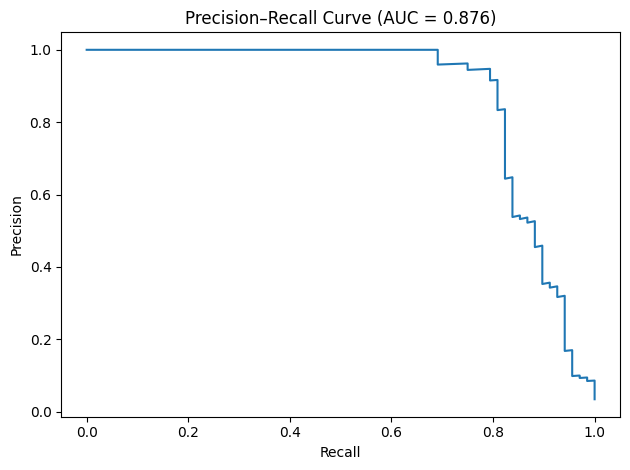

In [4]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# 1) Get the predicted probabilities for the positive class
probs = xgb.predict_proba(X_te)[:, 1]

# 2) Compute precision–recall curve and its AUC
prec, rec, thr = precision_recall_curve(y_te, probs)
pr_auc = auc(rec, prec)

# 3) Plot
plt.figure()
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve (AUC = {pr_auc:.3f})')
plt.tight_layout()
plt.show()


In [5]:
from sklearn.metrics import precision_recall_curve

# assume you already have `probs = xgb.predict_proba(X_te)[:,1]`
# and `y_te`

prec, rec, thr = precision_recall_curve(y_te, probs)

def find_thresholds(prec, rec, thr, p_min, r_min):
    # precision_recall_curve returns arrays prec,rec of length N+1 and thr of length N
    # we align thr[i] with (prec[i], rec[i]) for i in range(len(thr))
    valid = [
        (thr[i], prec[i], rec[i])
        for i in range(len(thr))
        if prec[i] >= p_min and rec[i] >= r_min
    ]
    if not valid:
        print(f"No threshold with precision ≥{p_min:.2f} and recall ≥{r_min:.2f}")
    else:
        print(f"Thresholds with P≥{p_min:.2f} & R≥{r_min:.2f}:")
        for t, p, r in valid:
            print(f"  thr={t:.4f} → precision={p:.3f}, recall={r:.3f}")

# check for both 0.85 and 0.80
for target in [0.85, 0.80]:
    find_thresholds(prec, rec, thr, target, target)


No threshold with precision ≥0.85 and recall ≥0.85
Thresholds with P≥0.80 & R≥0.80:
  thr=0.4881 → precision=0.800, recall=0.824
  thr=0.5295 → precision=0.812, recall=0.824
  thr=0.5339 → precision=0.824, recall=0.824
  thr=0.5980 → precision=0.836, recall=0.824
  thr=0.6035 → precision=0.833, recall=0.809
  thr=0.6069 → precision=0.846, recall=0.809
  thr=0.6143 → precision=0.859, recall=0.809
  thr=0.6506 → precision=0.873, recall=0.809
  thr=0.6884 → precision=0.887, recall=0.809
  thr=0.7052 → precision=0.902, recall=0.809
  thr=0.7293 → precision=0.917, recall=0.809


In [6]:
import pandas as pd
from IPython.display import display

# 1) Reconstruct your test‐set DataFrame, preserving the original df index
te = X_te.copy()                 # X_te has the same index as df
te['y_true'] = y_te
te['y_pred'] = preds

# 2) Add the failure‐mode columns from the original df
fail_cols = ['twf','hdf','pwf','osf','rnf']
te[fail_cols] = df.loc[X_te.index, fail_cols]

# 3) Extract False Negatives & False Positives
fn = te[(te.y_true == 1) & (te.y_pred == 0)]
fp = te[(te.y_true == 0) & (te.y_pred == 1)]

# 4) (Optional) Narrow to TWF‐specific errors
fn_twf = fn[fn.twf == 1]
fp_twf = fp[fp.twf == 1]

# 5) Display
print(" False Negatives (all modes):")
display(fn)

print("\n False Positives (all modes):")
display(fp)

print("\n False Negatives (TWF only):")
display(fn_twf)

print("\n False Positives (TWF only):")
display(fp_twf)


 False Negatives (all modes):


,type,process_temp,rot_speed,torque,tool_wear,temp_diff,heating_risk_scaled,power,wear_z,mechanical_work,y_true,y_pred,twf,hdf,pwf,osf,rnf
9174,2,308.9,1871,25.6,200,11.1,4.815077,5015.836672,1.430279,9.579520,1,0,1,0,0,0,0
2671,3,309.3,1399,41.9,221,9.6,7.445794,6138.487432,1.803924,12.954600,1,0,1,0,0,0,0
2864,5,309.4,1380,47.6,246,8.8,8.234518,6878.847360,2.196892,16.159248,1,0,1,0,0,0,0
3695,2,311.3,1530,37.3,207,9.1,7.182359,5976.265680,1.539555,11.813283,1,0,1,0,0,0,0
1085,2,307.8,1385,56.4,202,10.8,6.685385,8180.098080,1.461501,15.779028,1,0,0,0,0,1,0
5399,5,312.4,1411,53.8,246,9.6,7.382470,7949.483696,2.196892,18.674303,1,0,0,0,0,1,0
7087,2,310.3,1648,30.5,217,9.7,6.255629,5263.646080,1.695663,10.907288,1,0,1,0,0,0,0
2941,3,309.6,1996,19.8,203,8.9,5.629235,4138.618176,1.518412,8.022722,1,0,1,0,0,0,0
9015,2,308.1,1431,49.7,210,10.9,6.411119,7447.759704,1.586387,14.935347,1,0,0,0,0,0,0
4778,5,312.2,1371,54.6,112,8.6,8.481332,7838.983152,0.072610,8.383939,1,0,0,1,0,0,0



 False Positives (all modes):


,type,process_temp,rot_speed,torque,tool_wear,temp_diff,heating_risk_scaled,power,wear_z,mechanical_work,y_true,y_pred,twf,hdf,pwf,osf,rnf
4231,2,310.8,1340,47.8,54,8.6,8.677542,6707.525440,-0.848897,3.458808,0,1,0,0,0,0,0
3794,3,310.8,1356,48.3,36,8.6,8.575152,6858.615456,-1.130505,2.357813,0,1,0,0,0,0,0
7086,2,310.4,2514,13.4,215,9.8,4.058902,3527.765472,1.664441,7.242834,0,1,0,0,0,0,0



 False Negatives (TWF only):


,type,process_temp,rot_speed,torque,tool_wear,temp_diff,heating_risk_scaled,power,wear_z,mechanical_work,y_true,y_pred,twf,hdf,pwf,osf,rnf
9174,2,308.9,1871,25.6,200,11.1,4.815077,5015.836672,1.430279,9.579520,1,0,1,0,0,0,0
2671,3,309.3,1399,41.9,221,9.6,7.445794,6138.487432,1.803924,12.954600,1,0,1,0,0,0,0
2864,5,309.4,1380,47.6,246,8.8,8.234518,6878.847360,2.196892,16.159248,1,0,1,0,0,0,0
3695,2,311.3,1530,37.3,207,9.1,7.182359,5976.265680,1.539555,11.813283,1,0,1,0,0,0,0
7087,2,310.3,1648,30.5,217,9.7,6.255629,5263.646080,1.695663,10.907288,1,0,1,0,0,0,0
2941,3,309.6,1996,19.8,203,8.9,5.629235,4138.618176,1.518412,8.022722,1,0,1,0,0,0,0
7849,3,311.7,1374,47.9,222,11.4,6.384228,6892.104912,1.819785,14.610841,1,0,1,0,0,0,0
1996,3,308.0,1416,38.2,198,9.6,7.356402,5664.430464,1.439103,10.710058,1,0,1,0,0,0,0
4034,2,310.8,1615,29.0,235,8.8,7.036307,4904.561200,1.976657,11.006225,1,0,1,0,0,0,0



 False Positives (TWF only):


,type,process_temp,rot_speed,torque,tool_wear,temp_diff,heating_risk_scaled,power,wear_z,mechanical_work,y_true,y_pred,twf,hdf,pwf,osf,rnf


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score,precision_score, recall_score, f1_score

# 1) Define your feature sets
vanilla_features = ['type', 'process_temp', 'rot_speed', 'torque', 'tool_wear']
synergy_features = ['temp_diff', 'heating_risk_scaled', 'power', 'wear_z', 'mechanical_work']
all_features     = vanilla_features + synergy_features

# 2) Prepare X, y
X = df[all_features]
y = df['machine_failure']

# 3) Train/Test split (stratified)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4) Compute imbalance weight
scale_pos = (1 - y_tr.mean()) / y_tr.mean()

# 5) Train & evaluate two models
results = []
for name, feats in [
    ("Vanilla only", vanilla_features),
    ("With synergic", all_features)
]:
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos,
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )
    model.fit(X_tr[feats], y_tr)

    probs = model.predict_proba(X_te[feats])[:,1]
    preds = (probs >= 0.5).astype(int)   # default threshold

    print(f"\n=== {name} Features ===")
    print(classification_report(y_te, preds, digits=4))
    print("ROC AUC:", roc_auc_score(y_te, probs))

    results.append({
        'Model': name,
        'Accuracy': model.score(X_te[feats], y_te),
        'Precision': precision_score(y_te, preds),
        'Recall': recall_score(y_te, preds),
        'F1 Score': f1_score(y_te, preds),
        'ROC AUC': roc_auc_score(y_te, probs)
    })

# 6) (Optional) Tabulate results
import pandas as pd
res_df = pd.DataFrame(results)
print("\nSummary comparison:")
print(res_df)


d:\predictive maintenence\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Vanilla only Features ===
              precision    recall  f1-score   support

           0     0.9873    0.9638    0.9754      1932
           1     0.3860    0.6471    0.4835        68

    accuracy                         0.9530      2000
   macro avg     0.6866    0.8054    0.7294      2000
weighted avg     0.9668    0.9530    0.9587      2000

ROC AUC: 0.9469956460845208


d:\predictive maintenence\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== With synergic Features ===
              precision    recall  f1-score   support

           0     0.9938    0.9933    0.9935      1932
           1     0.8116    0.8235    0.8175        68

    accuracy                         0.9875      2000
   macro avg     0.9027    0.9084    0.9055      2000
weighted avg     0.9876    0.9875    0.9875      2000

ROC AUC: 0.9775986481549142

Summary comparison:
           Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0   Vanilla only    0.9530   0.385965  0.647059  0.483516  0.946996
1  With synergic    0.9875   0.811594  0.823529  0.817518  0.977599


In [8]:
import pandas as pd

for feat in synergy_features:
    corr = df[feat].corr(df['machine_failure'])
    print(f"{feat:20s}  correlation with failure: {corr:.3f}")


temp_diff             correlation with failure: -0.112
heating_risk_scaled   correlation with failure: 0.178
power                 correlation with failure: 0.176
wear_z                correlation with failure: 0.105
mechanical_work       correlation with failure: 0.164


In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc
)

# --- Define feature sets ---
vanilla_features = ['type', 'process_temp', 'rot_speed', 'torque', 'tool_wear']
synergy_features = ['temp_diff', 'heating_risk_scaled', 'power', 'wear_z', 'mechanical_work']
full_features = vanilla_features + synergy_features

# --- Extract X, y from df ---
X = df.copy()
y = X.pop('machine_failure')

# --- XGBoost configuration ---
scale_pos = (1 - y.mean()) / y.mean()
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,
    scale_pos_weight=scale_pos,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

# --- Cross-validation settings ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'precision': 'precision',
    'recall':    'recall',
    'f1':        'f1',
    'roc_auc':   'roc_auc',
    'pr_auc':    'average_precision'
}

def evaluate_features(feature_set, name):
    print(f"\n===== {name} Features =====")

    # 1) 5-fold cross-val
    cv_res = cross_validate(model, X[feature_set], y, cv=cv, scoring=scoring, n_jobs=-1)
    cv_summary = pd.DataFrame({
        metric: cv_res[f'test_{metric}'].mean()
        for metric in scoring
    }, index=['mean']).T
    print("\n5-Fold CV metrics:")
    print(cv_summary)

    # 2) Train/test split evaluation
    X_tr, X_te, y_tr, y_te = train_test_split(
        X[feature_set], y, test_size=0.2, stratify=y, random_state=42
    )
    model.fit(X_tr, y_tr)
    probs = model.predict_proba(X_te)[:,1]
    preds = (probs >= 0.5).astype(int)

    print("\nTest-set classification report:")
    print(classification_report(y_te, preds, digits=4))
    roc = roc_auc_score(y_te, probs)
    prec, rec, _ = precision_recall_curve(y_te, probs)
    pr = auc(rec, prec)
    print(f"ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")

# --- Execute comparisons ---
evaluate_features(vanilla_features, "Vanilla")
evaluate_features(full_features, "Full (with synergy)")



===== Vanilla Features =====

5-Fold CV metrics:
               mean
precision  0.347676
recall     0.713696
f1         0.467040
roc_auc    0.957747
pr_auc     0.586864

Test-set classification report:
              precision    recall  f1-score   support

           0     0.9863    0.9653    0.9757      1932
           1     0.3853    0.6176    0.4746        68

    accuracy                         0.9535      2000
   macro avg     0.6858    0.7915    0.7251      2000
weighted avg     0.9658    0.9535    0.9586      2000

ROC-AUC: 0.949 | PR-AUC: 0.593

===== Full (with synergy) Features =====

5-Fold CV metrics:
               mean
precision  0.717374
recall     0.828929
f1         0.768003
roc_auc    0.977615
pr_auc     0.864709

Test-set classification report:
              precision    recall  f1-score   support

           0     0.9938    0.9922    0.9930      1932
           1     0.7887    0.8235    0.8058        68

    accuracy                         0.9865      2000
   mac

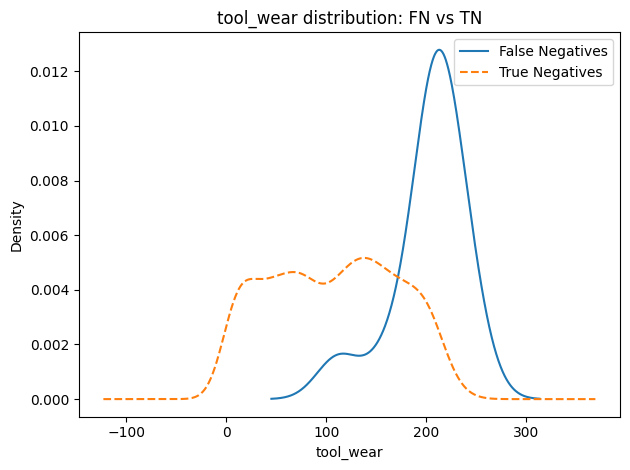

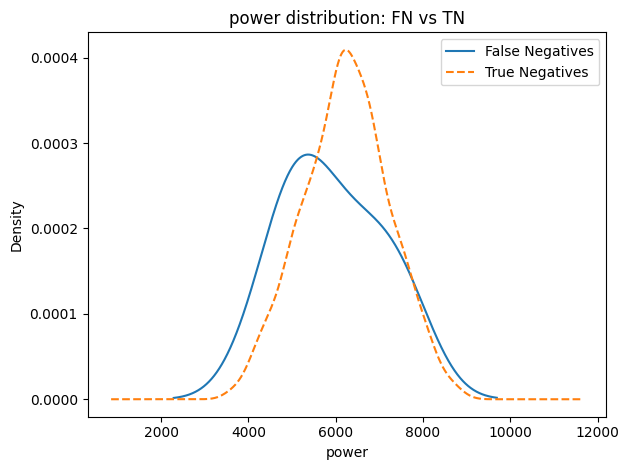

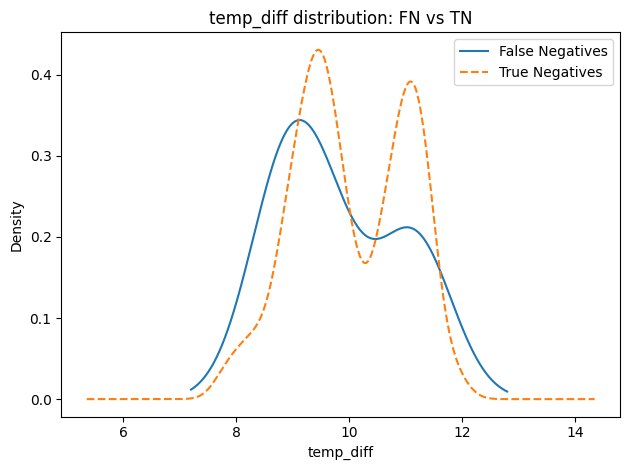

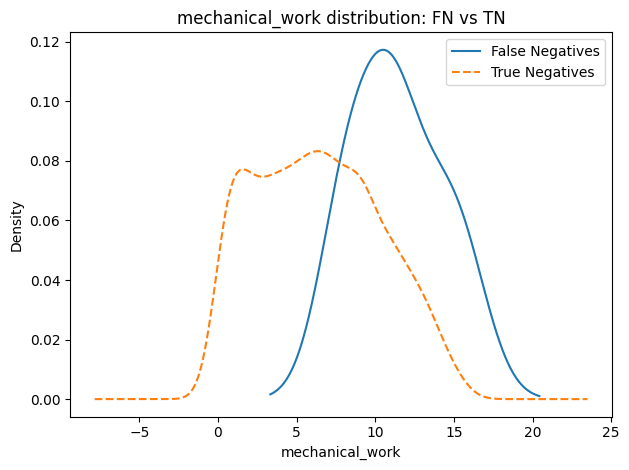

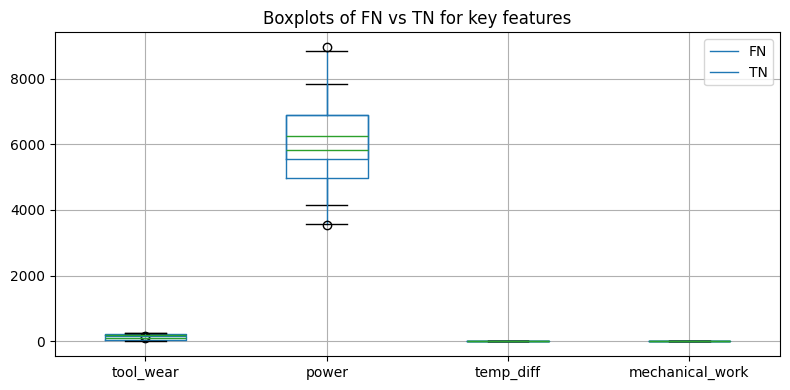

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 1) Reconstruct the test‐set DataFrame ---
# (Assumes you still have df, X_te, y_te and preds in your notebook)

te = X_te.copy()
te['y_true'] = y_te
te['y_pred'] = preds

# Bring in your raw failure‐mode columns if you want them too:
fail_cols = ['twf','hdf','pwf','osf','rnf']
te[fail_cols] = df.loc[X_te.index, fail_cols]

# --- 2) Define FN & TN subsets ---
fn = te[(te.y_true == 1) & (te.y_pred == 0)]
tn = te[(te.y_true == 0) & (te.y_pred == 0)]

# --- 3) Features to compare ---
features = ['tool_wear', 'power', 'temp_diff', 'mechanical_work']

# --- 4) KDE plots for each feature ---
for feat in features:
    plt.figure()
    # pandas’ built-in KDE → matplotlib
    fn[feat].plot(kind='kde', label='False Negatives')
    tn[feat].plot(kind='kde', label='True Negatives', linestyle='--')
    plt.title(f"{feat} distribution: FN vs TN")
    plt.xlabel(feat)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 5) (Optional) Boxplots for a quick numeric summary ---
plt.figure(figsize=(8,4))
data = [fn[features], tn[features]]
pd.DataFrame(data[0]).boxplot()
pd.DataFrame(data[1]).boxplot()
plt.xticks(
    [i+1 for i in range(len(features))],
    features
)
plt.legend(['FN','TN'])
plt.title("Boxplots of FN vs TN for key features")
plt.tight_layout()
plt.show()


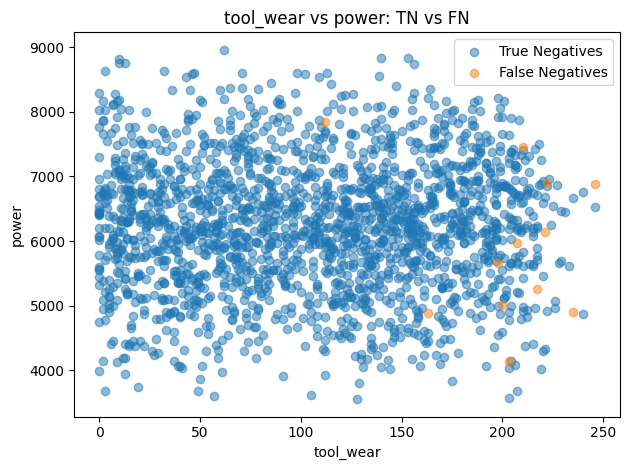

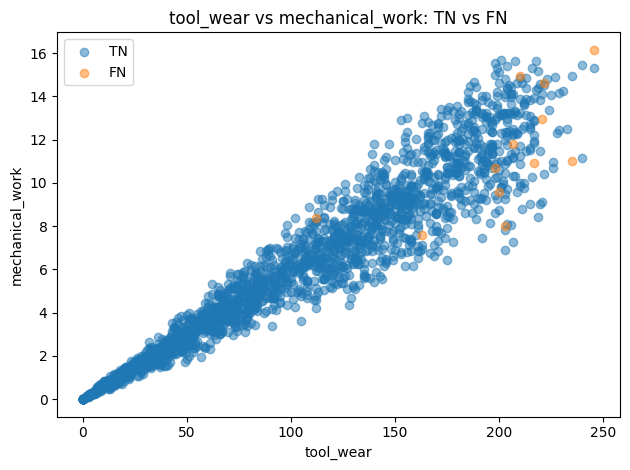

In [11]:
import matplotlib.pyplot as plt

# 1) Reconstruct the test‐set DataFrame
te = X_te.copy().reset_index(drop=True)
te['y_true'] = y_te.reset_index(drop=True)
te['y_pred'] = preds
fail_cols = ['twf','hdf','pwf','osf','rnf']
te[fail_cols] = df.loc[X_te.index, fail_cols].reset_index(drop=True)

# 2) Define False Negatives vs True Negatives
fn = te[(te.y_true == 1) & (te.y_pred == 0)]
tn = te[(te.y_true == 0) & (te.y_pred == 0)]

# 3) Scatter: tool_wear vs power
plt.figure()
plt.scatter(tn['tool_wear'], tn['power'], alpha=0.5, label='True Negatives')
plt.scatter(fn['tool_wear'], fn['power'], alpha=0.5, label='False Negatives')
plt.xlabel('tool_wear')
plt.ylabel('power')
plt.title('tool_wear vs power: TN vs FN')
plt.legend()
plt.tight_layout()
plt.show()

# 4) Try another scatter: tool_wear vs mechanical_work
plt.figure()
plt.scatter(tn['tool_wear'], tn['mechanical_work'], alpha=0.5, label='TN')
plt.scatter(fn['tool_wear'], fn['mechanical_work'], alpha=0.5, label='FN')
plt.xlabel('tool_wear')
plt.ylabel('mechanical_work')
plt.title('tool_wear vs mechanical_work: TN vs FN')
plt.legend()
plt.tight_layout()
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0     0.9938    0.9933    0.9935      1932
           1     0.8116    0.8235    0.8175        68

    accuracy                         0.9875      2000
   macro avg     0.9027    0.9084    0.9055      2000
weighted avg     0.9876    0.9875    0.9875      2000

ROC-AUC: 0.978
PR-AUC : 0.876


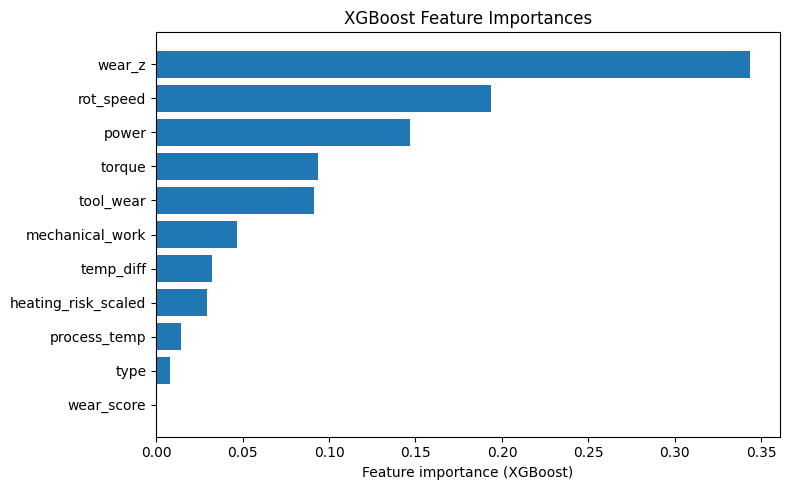

In [12]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

# --- 1) Build the wear_score feature ---
# expert “safe limit” in minutes:
T = 200  
# transition sharpness:
k = 10   

df['wear_score'] = 1 / (1 + np.exp(-(df['tool_wear'] - T) / k))

# --- 2) Define your feature list ---
features = [
    'type', 'process_temp', 'rot_speed', 'torque', 'tool_wear',
    'temp_diff', 'heating_risk_scaled', 'power', 'wear_z',
    'mechanical_work', 'wear_score'
]

# --- 3) Prepare X, y and split ---
X = df[features]
y = df['machine_failure']

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 4) Train XGBoost with imbalance weight ---
scale_pos = (1 - y_tr.mean()) / y_tr.mean()
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,
    scale_pos_weight=scale_pos,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
model.fit(X_tr, y_tr)

# --- 5) Evaluate on the test set ---
probs = model.predict_proba(X_te)[:, 1]
preds = (probs >= 0.5).astype(int)

print("Classification Report:\n")
print(classification_report(y_te, preds, digits=4))

roc = roc_auc_score(y_te, probs)
prec, rec, _ = precision_recall_curve(y_te, probs)
pr  = auc(rec, prec)
print(f"ROC-AUC: {roc:.3f}")
print(f"PR-AUC : {pr:.3f}")

# --- 6) Plot feature importances ---
imp_vals = model.feature_importances_
imp_names = features

imp_df = pd.DataFrame({
    'feature': imp_names,
    'importance': imp_vals
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(imp_df['feature'], imp_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature importance (XGBoost)")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()


5-Fold CV results (all features):
               mean
precision  0.734270
recall     0.831870
f1         0.778967
roc_auc    0.977736
pr_auc     0.861487

Test-set classification report:
              precision    recall  f1-score   support

           0     0.9938    0.9928    0.9933      1932
           1     0.8000    0.8235    0.8116        68

    accuracy                         0.9870      2000
   macro avg     0.8969    0.9081    0.9024      2000
weighted avg     0.9872    0.9870    0.9871      2000

ROC-AUC: 0.982 | PR-AUC: 0.882


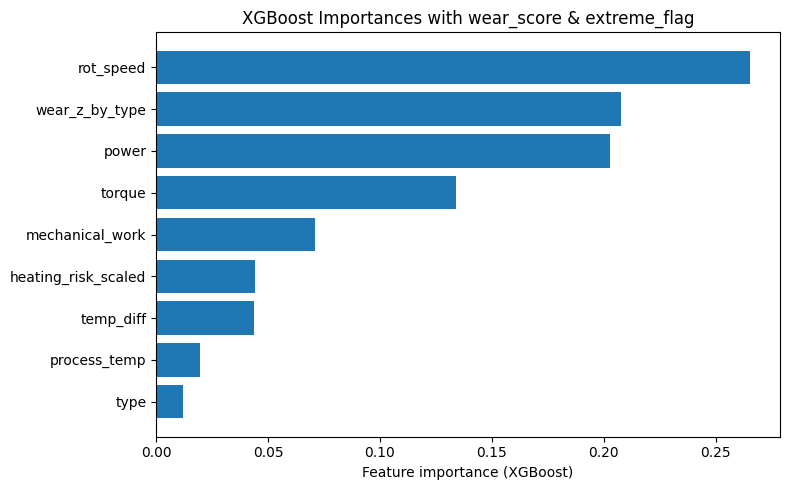

In [13]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt

# --- 1) Engineer the new features ---
# Sigmoid “wear_score”
T, k = 180, 20
df['wear_score'] = 1 / (1 + np.exp(-(df['tool_wear'] - T) / k))

df['wear_z_by_type'] = (
    df.groupby('type')['tool_wear']
      .transform(lambda x: (x - x.mean()) / x.std())
)


# Binary “extreme_flag” at 95th percentile
tw_thr  = df['tool_wear'].quantile(0.95)
pwr_thr = df['power']    .quantile(0.95)
df['extreme_flag'] = (
    (df.tool_wear >= tw_thr) &
    (df.power      >= pwr_thr)
).astype(int)

# --- 2) Define your features and target ---
features = [
    'type','process_temp','rot_speed','torque',
    'temp_diff','heating_risk_scaled','power',
    'mechanical_work', 'wear_z_by_type'
]
X = df[features]
y = df['machine_failure']

# --- 3) XGB config with class‐imbalance handling ---
scale_pos = (1 - y.mean()) / y.mean()
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,
    scale_pos_weight=scale_pos,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

# --- 4) 5-fold Stratified CV ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'precision':    'precision',
    'recall':       'recall',
    'f1':           'f1',
    'roc_auc':      'roc_auc',
    'pr_auc':       'average_precision'
}
cv_res = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

cv_summary = pd.DataFrame({
    metric: cv_res[f'test_{metric}'].mean()
    for metric in scoring
}, index=['mean']).T

print("5-Fold CV results (all features):")
print(cv_summary)

# --- 5) Final train/test evaluation ---
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
model.fit(X_tr, y_tr)
probs = model.predict_proba(X_te)[:,1]
preds = (probs >= 0.5).astype(int)

print("\nTest-set classification report:")
print(classification_report(y_te, preds, digits=4))

roc = roc_auc_score(y_te, probs)
prec, rec, _ = precision_recall_curve(y_te, probs)
pr  = auc(rec, prec)
print(f"ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")

# --- 6) Plot feature importances ---
imp_df = pd.DataFrame({
    'feature':    features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(imp_df['feature'], imp_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature importance (XGBoost)")
plt.title("XGBoost Importances with wear_score & extreme_flag")
plt.tight_layout()
plt.show()




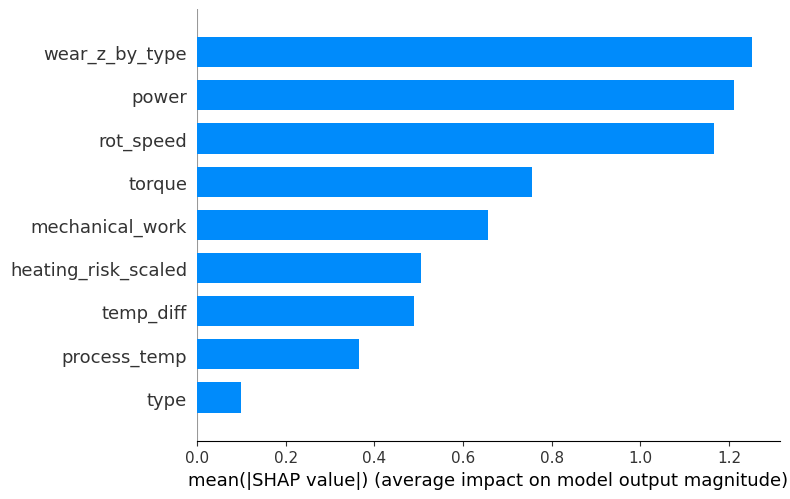

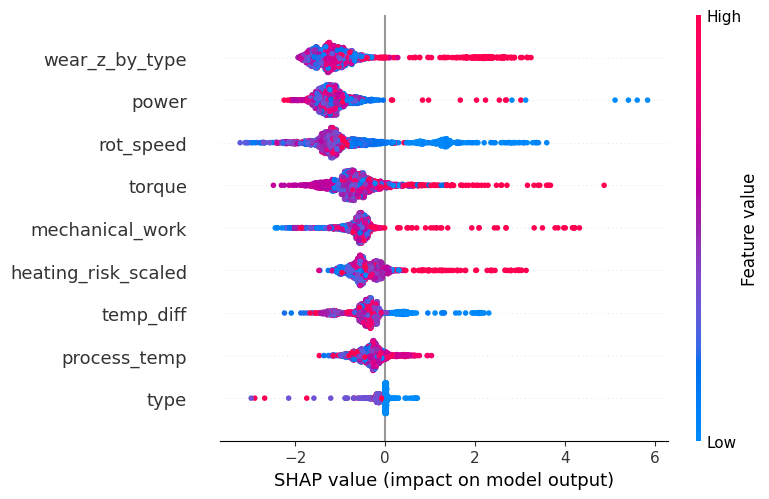

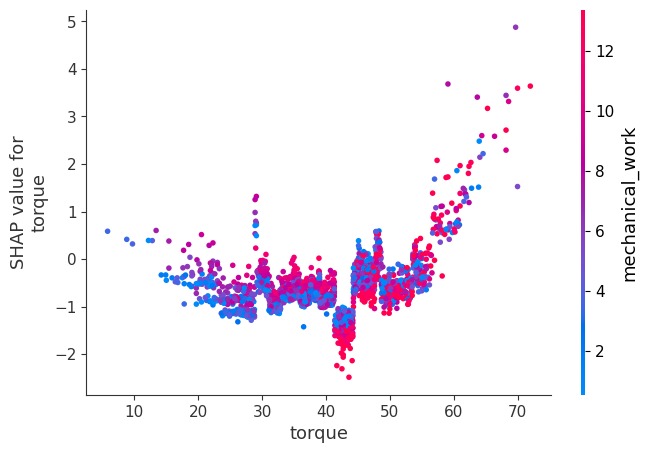

In [14]:
import shap
import os
import matplotlib.pyplot as plt

# Force CPU-only mode (optional but avoids GPU issues)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values on test set
shap_values = explainer.shap_values(X_te)

# 1. Global feature importance (bar plot)
shap.summary_plot(shap_values, X_te, plot_type="bar")

# 2. Detailed summary (dot swarm plot)
shap.summary_plot(shap_values, X_te)

# 3. Dependence plot for a key feature (try others like 'power', 'wear_score', etc.)
shap.dependence_plot("torque", shap_values, X_te)

# Optional: Zoom in on a single prediction (e.g., a false positive or false negative)
# shap.force_plot(explainer.expected_value, shap_values[i], X_te.iloc[i])  # i = index of a test sample


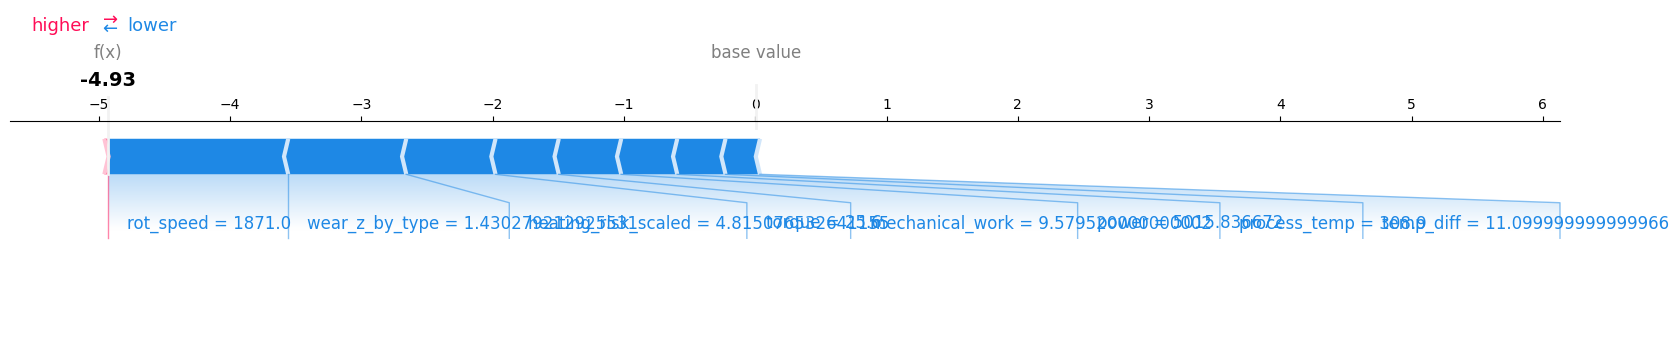

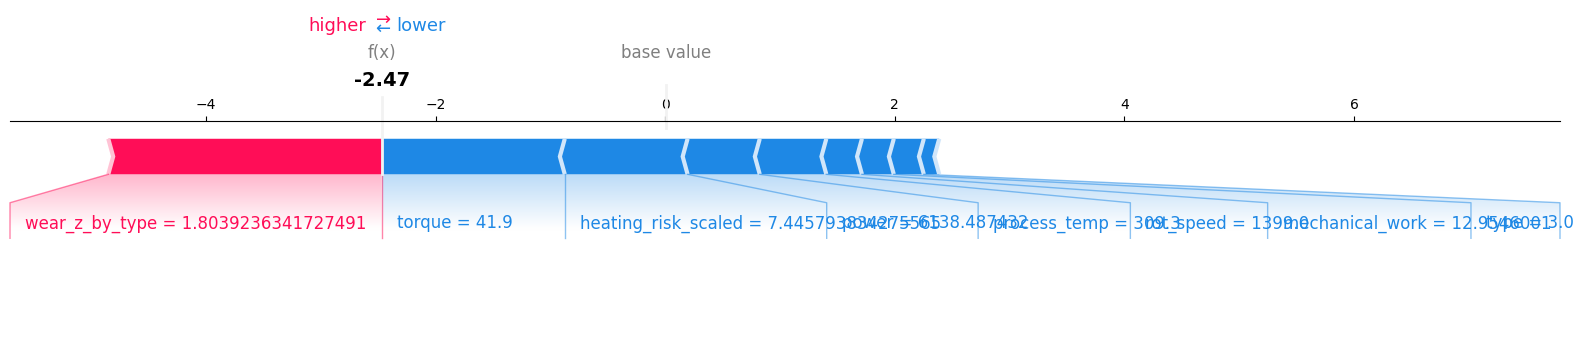

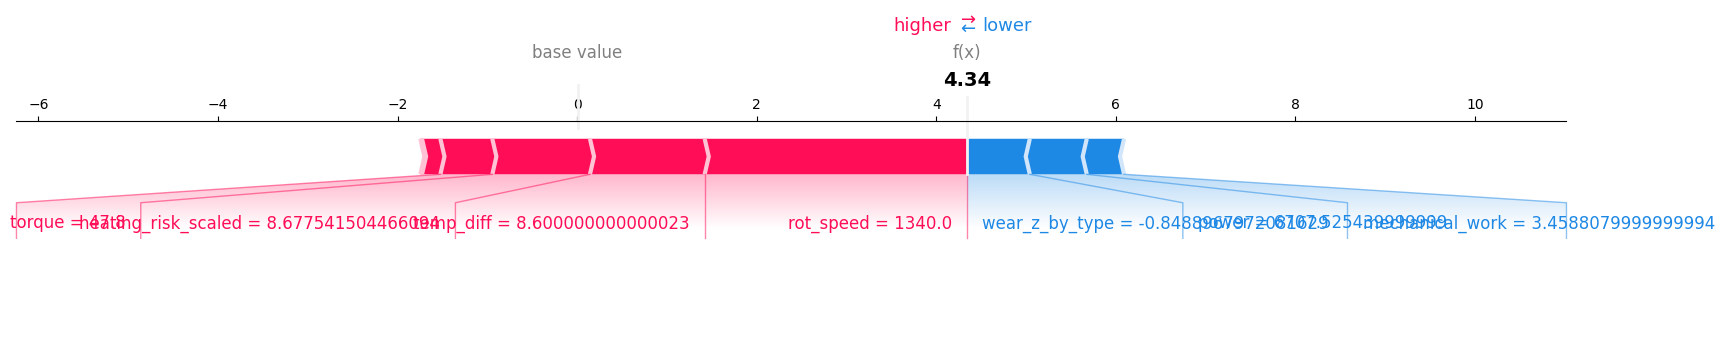

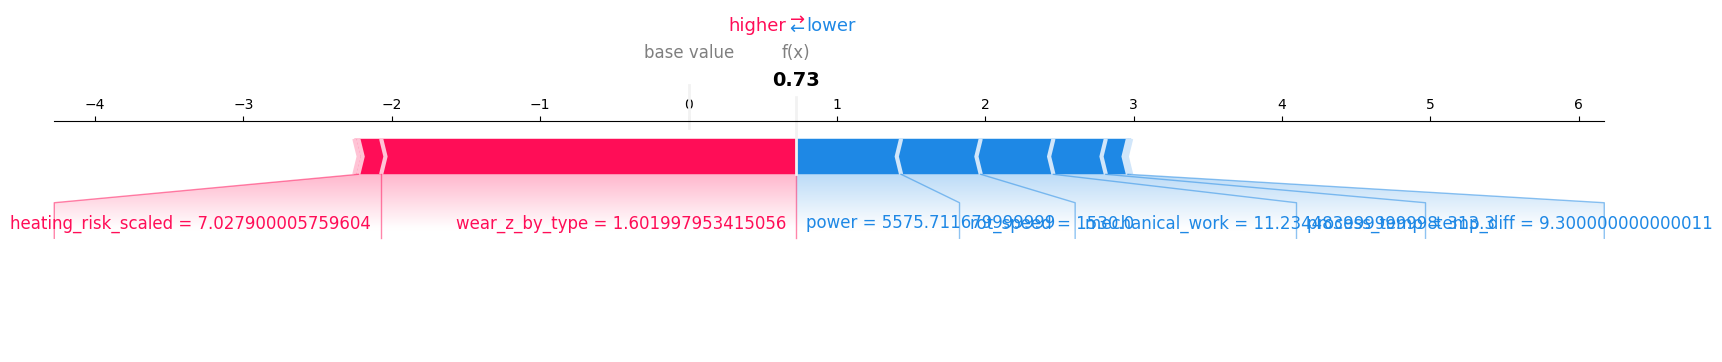

In [15]:
import shap

# 1) find the original indices of your FNs and FPs
fn_idxs = X_te[(y_te == 1) & (preds == 0)].index[:2].tolist()
fp_idxs = X_te[(y_te == 0) & (preds == 1)].index[:2].tolist()

for orig_idx in fn_idxs + fp_idxs:
    # map the original label (e.g. 9174) to its positional index in X_te
    pos = X_te.index.get_loc(orig_idx)
    
    # now pos is in [0..len(X_te)-1], matching shap_values
    shap.force_plot(
        explainer.expected_value,
        shap_values[pos],
        X_te.iloc[pos],
        matplotlib=True
    )


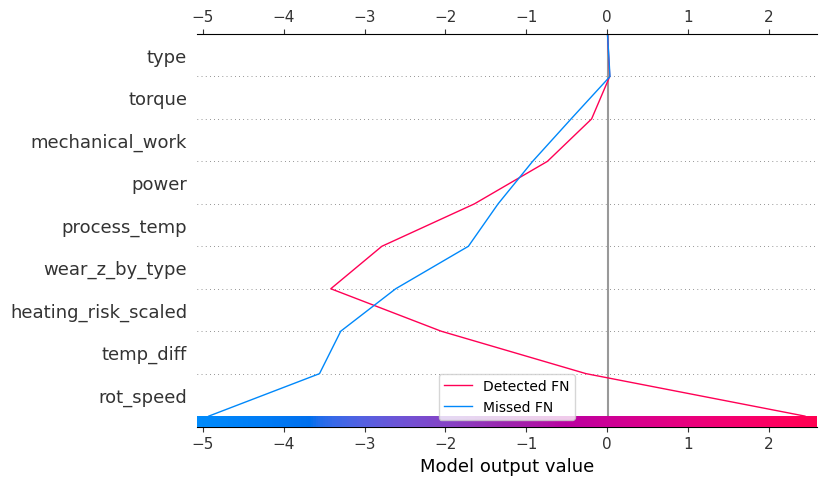

In [16]:
import matplotlib.pyplot as plt
# pick one correctly‐detected failure and one missed failure
orig_good = X_te[(y_te == 1) & (preds == 1)].index[0]
orig_bad  = X_te[(y_te == 1) & (preds == 0)].index[0]

# map to positional indices
pos_good = X_te.index.get_loc(orig_good)
pos_bad  = X_te.index.get_loc(orig_bad)

shap.decision_plot(
    explainer.expected_value,
    shap_values[[pos_good, pos_bad]],
    X_te.iloc[[pos_good, pos_bad]],
    legend_labels=["Detected FN", "Missed FN"],
    feature_display_range=slice(None, 10),
    
)


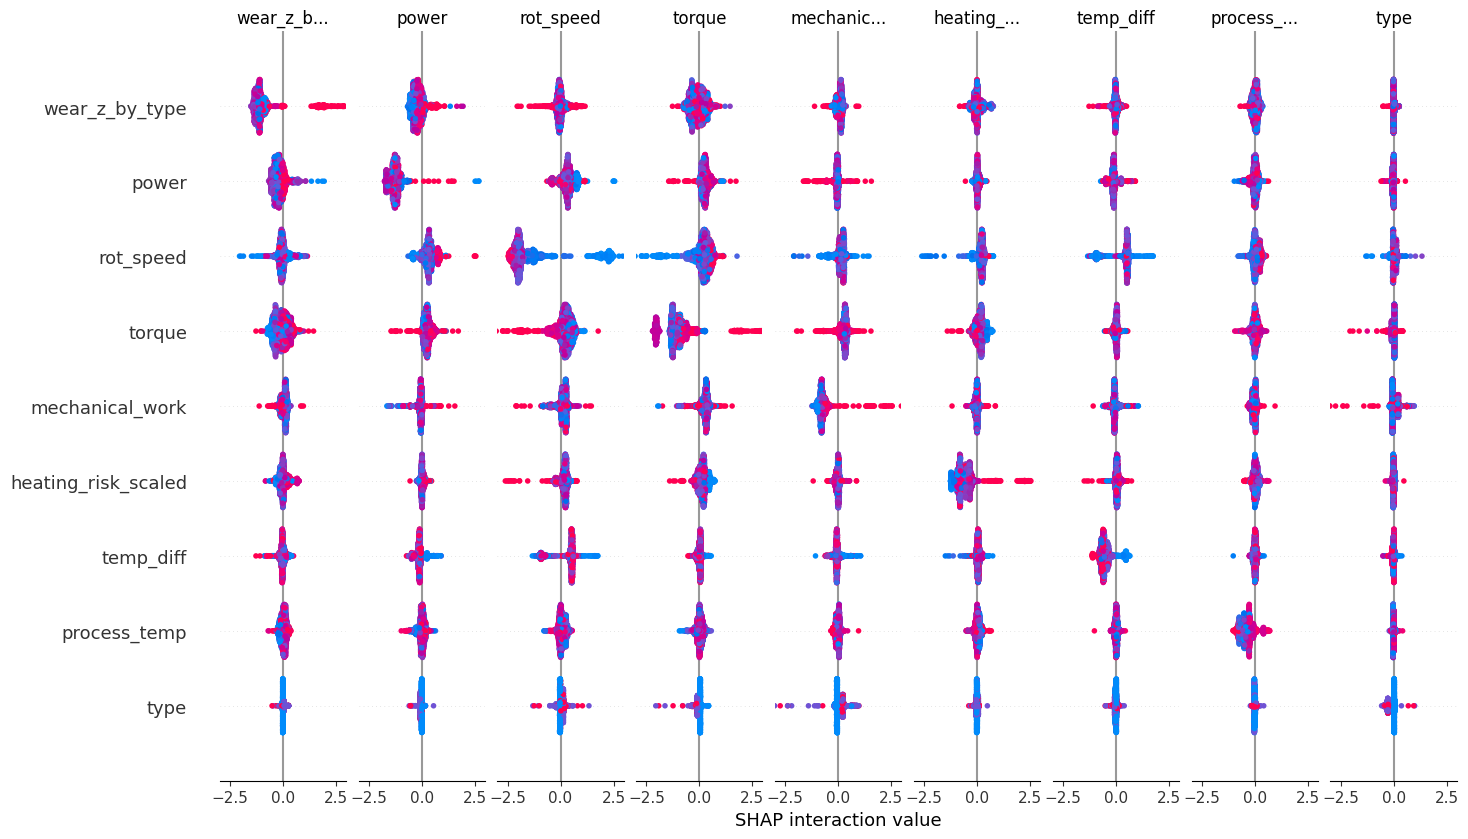

In [17]:
shap_inter = explainer.shap_interaction_values(X_te)
shap.summary_plot(shap_inter, X_te, max_display=10)


In [18]:
from sklearn.cluster import KMeans
import numpy as np

shap_arr = np.array(shap_values)  # shape (n_samples, n_features)
clust   = KMeans(3, random_state=42).fit(shap_arr)

cluster_df = pd.DataFrame({
    "cluster": clust.labels_,
    "y_true":  y_te.values,
    "pred":    preds
}, index=X_te.index)

print(cluster_df.groupby(["cluster","y_true","pred"]).size())


cluster  y_true  pred
0        0       0        225
                 1          3
         1       0          1
                 1         46
1        0       0        105
                 1         11
         1       0          8
                 1         10
2        0       0       1588
         1       0          3
dtype: int64


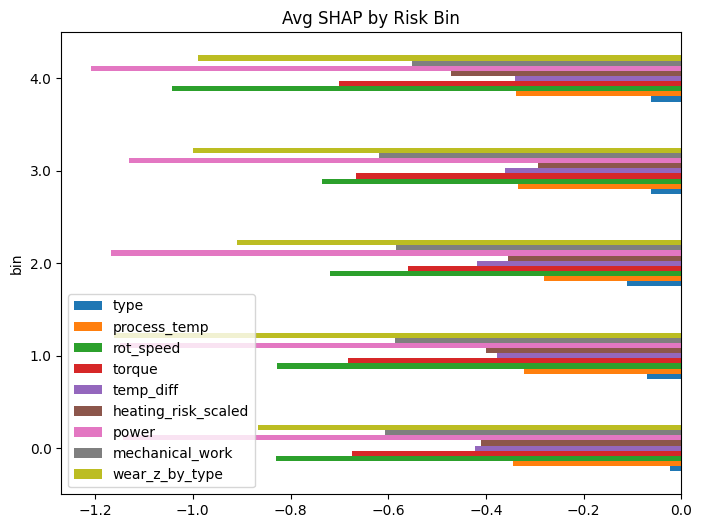

In [19]:
# add bins
X_te = X_te.copy()
X_te["prob"] = probs
X_te["bin"]  = pd.qcut(probs, 5, labels=False)

# build a DataFrame of just the SHAP values with your original feature names
shap_df = pd.DataFrame(shap_values, columns=features)

mean_shap = pd.concat([shap_df, X_te[["bin"]]], axis=1).groupby("bin").mean()

mean_shap.plot.barh(figsize=(8,6))
plt.title("Avg SHAP by Risk Bin")
plt.show()


In [20]:
df.head(2)

,type,process_temp,rot_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf,temp_diff,heating_risk_scaled,power,wear_z,mechanical_work,wear_score,wear_z_by_type,extreme_flag
0,3,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,6.140431,6951.606816,-1.701529,0.000000,0.000123,-1.701529,0
1,2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,6.764069,6826.738688,-1.645047,0.195571,0.000143,-1.645047,0


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

features = ['type','process_temp','rot_speed','torque',
            'temp_diff','heating_risk_scaled','power','wear_z_by_type']
modes    = ['twf','hdf','pwf','osf','rnf']

X = df[features]
y = df[modes]

# 3a) Approach A: Global multi‐label classification ----------------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2,
                                          random_state=42)

# Use XGBoost wrapped in MultiOutputClassifier
base_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                         scale_pos_weight=1, random_state=42)
multi_clf = MultiOutputClassifier(base_clf, n_jobs=-1)
multi_clf.fit(X_tr, y_tr)

# Predict & evaluate
y_pred = multi_clf.predict(X_te)
print("=== Multi‐label Classification (All data) ===")
print(classification_report(y_te, y_pred, digits=4))

# 3b) Approach B: Two‐stage pipeline (optional) :contentReference[oaicite:3]{index=3}
# Stage 1: machine_failure filter
mf_clf = LGBMClassifier(class_weight='balanced', random_state=42)
mf_clf.fit(X_tr, df.loc[y_tr.index,'machine_failure'])
mf_pred = mf_clf.predict(X_te)

# Only try to classify modes where mf_pred == 1
ii = X_te.index[mf_pred==1]
X_fail_tr = X_tr[df.loc[y_tr.index,'machine_failure']==1]
y_fail_tr = y_tr.loc[df.loc[y_tr.index,'machine_failure']==1]
stage2 = {}
for mode in modes:
    clf2 = LGBMClassifier(class_weight='balanced', random_state=42)
    clf2.fit(X_fail_tr, y_fail_tr[mode])
    stage2[mode] = clf2

# Evaluate Stage 2
y2_pred = pd.DataFrame(index=ii)
for mode,clf2 in stage2.items():
    y2_pred[mode] = clf2.predict(X_te.loc[ii])
print("\n=== Two-Stage (on predicted failures) ===")
print(classification_report(y_te.loc[ii], y2_pred, digits=4))

# 4) Per‐mode threshold tuning (optional) ------------------------------------------------
# Example for twf
probas = multi_clf.estimators_[0].predict_proba(X_te)[:,1]
prec, rec, thr = precision_recall_curve(y_te['twf'], probas)
f1s = 2*prec*rec/(prec+rec+1e-9)
best = np.argmax(f1s)
print(f"\nTWF best threshold: {thr[best]:.4f}  →  P={prec[best]:.3f}, R={rec[best]:.3f}")

# 5) Summary metrics ----------------------------------------------------------------------
print("\n=== Final multi‐label F1 scores ===")
print("micro F1:", f1_score(y_te, y_pred, average='micro'))
print("macro F1:", f1_score(y_te, y_pred, average='macro'))

=== Multi‐label Classification (All data) ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        11
           1     1.0000    1.0000    1.0000        17
           2     0.9500    0.9500    0.9500        20
           3     0.9231    0.6667    0.7742        18
           4     0.0000    0.0000    0.0000         6

   micro avg     0.9231    0.6667    0.7742        72
   macro avg     0.5746    0.5233    0.5448        72
weighted avg     0.7308    0.6667    0.6935        72
 samples avg     0.0225    0.0215    0.0218        72

[LightGBM] [Info] Number of positive: 278, number of negative: 7722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1443
[LightGBM] [Info] Number of data points in the train set: 8000, number of used feat

In [24]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, classification_report

# ─── 1) Prepare DATA ───────────────────────────────────────────────────────────

features = ['type','process_temp','rot_speed','torque',
             'temp_diff','heating_risk_scaled','power','wear_z_by_type']

X_twf = df[features]             # all rows, all engineered features
y_twf = df['twf']                # 1 if TWF failure, else 0

# stratified train/val split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_twf, y_twf,
    test_size=0.2,
    stratify=y_twf,
    random_state=42
)

# ─── 2) Train TWF classifier ───────────────────────────────────────────────────
clf_twf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(1 - y_tr.mean()) / y_tr.mean(),
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
clf_twf.fit(X_tr, y_tr)

# ─── 3) Compute VAL probabilities ─────────────────────────────────────────────
probs = clf_twf.predict_proba(X_val)[:, 1]

# ─── 4) Find threshold that MAXIMIZES F1 ───────────────────────────────────────
prec, rec, thr = precision_recall_curve(y_val, probs)
f1s   = 2 * prec * rec / (prec + rec + 1e-12)

# the last entry of prec/rec has no matching thresh, so ignore it
best_idx    = f1s[:-1].argmax()
best_thresh = thr[best_idx]
best_f1     = f1s[best_idx]
best_prec   = prec[best_idx]
best_rec    = rec[best_idx]

print(f"→ Optimal TWF threshold = {best_thresh:.4f}")
print(f"   Precision = {best_prec:.3f}, Recall = {best_rec:.3f}, F₁ = {best_f1:.3f}")

# ─── 5) Evaluate at that threshold ────────────────────────────────────────────
y_pred_val = (probs >= best_thresh).astype(int)
print("\nClassification report @ optimal threshold:")
print(classification_report(y_val, y_pred_val, digits=4))



→ Optimal TWF threshold = 0.1100
   Precision = 0.083, Recall = 0.444, F₁ = 0.140

Classification report @ optimal threshold:
              precision    recall  f1-score   support

           0     0.9974    0.9779    0.9876      1991
           1     0.0833    0.4444    0.1404         9

    accuracy                         0.9755      2000
   macro avg     0.5404    0.7112    0.5640      2000
weighted avg     0.9933    0.9755    0.9838      2000




Mann-Whitney U test (TWF vs non-TWF):
                feature    U_stat       p_value
7       wear_z_by_type  444994.5  1.963444e-28
8      mechanical_work  407878.0  5.197255e-20
6                power  190975.0  5.195189e-02
3               torque  198674.5  1.212863e-01
0                 type  245410.5  3.322928e-01
4            temp_diff  213517.0  4.296204e-01
1         process_temp  242307.0  4.937986e-01
2            rot_speed  240019.5  5.706862e-01
5  heating_risk_scaled  239409.5  5.920877e-01

Logistic L1 |coefs| ranking:
 wear_z_by_type         5.269801
power                  0.233159
type                   0.108422
heating_risk_scaled    0.080945
rot_speed              0.079811
temp_diff              0.069060
process_temp           0.036042
torque                 0.000000
mechanical_work        0.000000
dtype: float64

False Positives (0):
Empty DataFrame
Columns: [type, process_temp, rot_speed, torque, temp_diff, heating_risk_scaled, power, wear_z_by_type, mechanical_wor

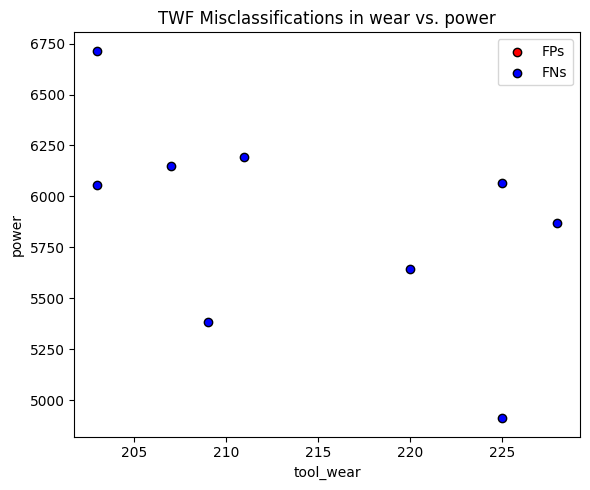

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# ─── 0) Setup ─────────────────────────────────────────────────────────────────────
features = [
    'type','process_temp','rot_speed','torque',
    'temp_diff','heating_risk_scaled','power','wear_z_by_type','mechanical_work'
]
y = df['twf']
X = df[features]

# ─── 1) Univariate tests ───────────────────────────────────────────────────────────
mw_results = []
for feat in features:
    stat, p = mannwhitneyu(X.loc[y==1, feat], X.loc[y==0, feat], alternative='two-sided')
    mw_results.append((feat, stat, p))
mw_df = pd.DataFrame(mw_results, columns=['feature','U_stat','p_value']).sort_values('p_value')
print("\nMann-Whitney U test (TWF vs non-TWF):\n", mw_df)

# ─── 2) Standardize AND keep as DataFrame ─────────────────────────────────────────
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=df.index, columns=features)

# ─── 3) Train/Val split (DataFrame keeps index) ────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X_scaled_df, y, test_size=0.2, stratify=y, random_state=42
)

# ─── 4) L1-penalized logistic for feature importances ──────────────────────────────
clf = LogisticRegressionCV(
    cv=5, penalty='l1', solver='saga', scoring='f1',
    max_iter=5000, random_state=42
).fit(X_tr, y_tr)

coefs = pd.Series(clf.coef_[0], index=features).abs().sort_values(ascending=False)
print("\nLogistic L1 |coefs| ranking:\n", coefs)

# ─── 5) Predict on X_te ────────────────────────────────────────────────────────────
probs = clf.predict_proba(X_te)[:,1]
preds = (probs >= 0.5).astype(int)

# ─── 6) Extract FP & FN indices ───────────────────────────────────────────────────
fp_mask = (y_te==0) & (preds==1)
fn_mask = (y_te==1) & (preds==0)

fp_idx = X_te.index[fp_mask]
fn_idx = X_te.index[fn_mask]

print(f"\nFalse Positives ({len(fp_idx)}):")
print(df.loc[fp_idx, features + ['twf','hdf','pwf','osf','rnf']])

print(f"\nFalse Negatives ({len(fn_idx)}):")
print(df.loc[fn_idx, features + ['twf','hdf','pwf','osf','rnf']])

# ─── 7) Visualize misclassifications in wear vs power ─────────────────────────────
plt.figure(figsize=(6,5))
plt.scatter(
    df.loc[fp_idx,'tool_wear'], df.loc[fp_idx,'power'],
    c='red', label='FPs', edgecolor='k'
)
plt.scatter(
    df.loc[fn_idx,'tool_wear'], df.loc[fn_idx,'power'],
    c='blue', label='FNs', edgecolor='k'
)
plt.xlabel('tool_wear'); plt.ylabel('power')
plt.title('TWF Misclassifications in wear vs. power')
plt.legend(); plt.tight_layout(); plt.show()


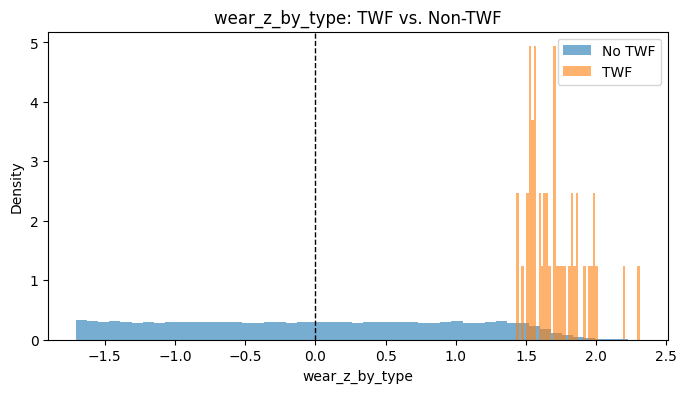

Optimal wear_z threshold = 1.804  →  Precision=0.139, Recall=0.304, F1=0.190


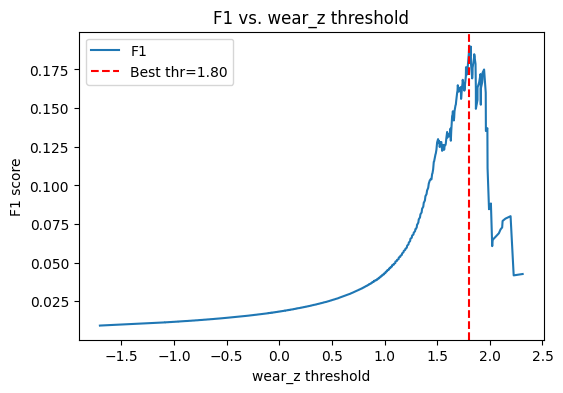

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# 1) Plot the distributions
plt.figure(figsize=(8,4))
plt.hist(df.loc[df.twf==0, 'wear_z_by_type'], bins=50, alpha=0.6, density=True, label='No TWF')
plt.hist(df.loc[df.twf==1, 'wear_z_by_type'], bins=50, alpha=0.6, density=True, label='TWF')
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('wear_z_by_type')
plt.ylabel('Density')
plt.legend()
plt.title('wear_z_by_type: TWF vs. Non-TWF')
plt.show()

# 2) Compute precision/recall curve on wear_z
y = df['twf'].values
scores = df['wear_z_by_type'].values  # higher = more likely TWF
prec, rec, thr = precision_recall_curve(y, scores)

# 3) Compute F1 at each threshold
f1 = 2 * prec * rec / (prec + rec + 1e-12)
best = f1.argmax()
opt_thr = thr[best]
print(f"Optimal wear_z threshold = {opt_thr:.3f}  →  Precision={prec[best]:.3f}, Recall={rec[best]:.3f}, F1={f1[best]:.3f}")

# 4) (Optional) Show the F1 curve
plt.figure(figsize=(6,4))
plt.plot(thr, f1[:-1], label='F1')
plt.axvline(opt_thr, color='r', linestyle='--', label=f'Best thr={opt_thr:.2f}')
plt.xlabel('wear_z threshold')
plt.ylabel('F1 score')
plt.legend()
plt.title('F1 vs. wear_z threshold')
plt.show()


In [30]:
# 1) Find the smallest wear_z_by_type at which a real TWF occurred
min_z = df.loc[df['twf']==1, 'wear_z_by_type'].min()
print(f"Minimum wear_z_by_type among true TWFs: {min_z:.3f}")

# 2) Choose a safety factor < 1.0 (the lower, the more conservative)
#    e.g. if you want to act 20% earlier in sigma‐space:
safety_factor = 0.8
threshold_z_safety = min_z * safety_factor
print(f"→ Safety‐factor threshold = {threshold_z_safety:.3f} (i.e. {safety_factor*100:.0f}% of min failure z)")

# 3) Build the rule‐based prediction
df['twf_rule_safety'] = (df['wear_z_by_type'] >= threshold_z_safety).astype(int)

# 4) Evaluate on your labeled data
from sklearn.metrics import classification_report
print("\nRule-based (safety-factor) TWF performance:")
print(classification_report(df['twf'], df['twf_rule_safety'], digits=4))


Minimum wear_z_by_type among true TWFs: 1.430
→ Safety‐factor threshold = 1.144 (i.e. 80% of min failure z)

Rule-based (safety-factor) TWF performance:
              precision    recall  f1-score   support

           0     1.0000    0.8372    0.9114      9954
           1     0.0276    1.0000    0.0537        46

    accuracy                         0.8379     10000
   macro avg     0.5138    0.9186    0.4825     10000
weighted avg     0.9955    0.8379    0.9074     10000

